<a href="https://colab.research.google.com/github/lecture-series-2021/lecture5/blob/main/lecture5_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 5: Machine Learning
- In this homework we will implement a neural network to learn to classify the type of iris plant from attributes of its flower, using the [UCI Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).
- Code written by Rakshit Kothari, originally from https://github.com/RSKothari/Learn-Backprop.


# Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import abc
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris

# convenience functions
def sigmoid_(x):
  return 1/(1 + np.exp(-x))

def softmax_(x):
  return np.exp(x)/np.sum(np.exp(x))

Class that defines our neural network model.
Useful resources:
- https://www.ics.uci.edu/~pjsadows/notes.pdf
- https://www.jasonosajima.com/backprop
- https://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf

[Abstract base class](https://pymotw.com/3/abc/) for a neural network (NN).
NN layers and even other NNs can derive from this class. They will have 
to re-implement the functions marked `@abc.abstractmethod`.

We will use the following terminology:
- `x`: input to a layer or the entire NN
- `y`: output of a layer or the entire NN
- `p`: learnable parameters in the layer or the entire NN
- `grad`: gradient of loss function w.r.t. `x`
- `update`: gradient of loss function w.r.t. `p`

In [2]:
class Module(metaclass=abc.ABCMeta):
  # Question: What is the purpose of this class?
  def __init__(self):
    # False indicates this NN is in training mode i.e. inputs will be stored for update computation later
    # True indicates this NN is in evaluation mode
    self.eval = True
    self.params = []  # by default, a module will have no learnable parameters
    self.g_params = []  # gradient of loss function w.r.t. self.params
    self.inputs = []  # inputs stored for update computation later
    self.g_inputs = []  # gradient of loss function w.r.t. input

  @abc.abstractmethod
  def forward(self, x):
    """
    NN forward pass i.e. compute output y from input x.
    Also stores x in self.inputs, because it will be used in self.backward()
    """

  @abc.abstractmethod
  def backward(self, g_outputs):
    """
    NN backward pass. This function calculates:
    - gradient of loss function w.r.t. its inputs self.inputs and stores it in self.g_inputs
    - gradient of loss function w.r.t. its learnable parameters self.params and stores it in self.g_params
    Inputs:
    - g_outputs: gradient of loss function w.r.t. its output. This comes from the next layer
    (recall the computation graph and chain rule explained in class)
    Returns: None
    """
    # If you are confused about backprop derivation,
    # please consider going over this article:
    # https://www.jasonosajima.com/backprop
  
  @abc.abstractmethod
  def grad_fn(self, x):
    """
    gradient of output w.r.t. input, for a single input
    recall chain equation dL_din = dL_dout * dout_din
    This function calculates dout_din
    """

  def zero_grad(self):
    """
    This function resets the NN i.e. clears out the stored inputs and gradients
    """
    self.inputs = []
    self.g_inputs = []

In [11]:
class ANN(Module):
    # Question: Why do we derive ANN from Module?
    def __init__(self, ):
      super(ANN, self).__init__()
      # Question: What does the "super" do?
      self.operations = []

    def forward(self, x):
      """
      Forward neural network operation. The network stores all inputs that passed
      through a layer. These inputs are used to compute the gradient and can be
      freed using the zero_grad() function
      """
      # Question: What does the attribute "operations" hold?
      for operation in self.operations:
        x = operation.forward(x)
      return x

    def backward(self, g_outputs):
      """
      Computes the gradient for each input saved in the layer and all learnable parameters
      """
      # Iterate through every operation in the network.
      # Question: What does "idx" and "operation" hold?
      # What is the importance of the "enumerate" function?
      # set_trace()
      for idx, operation in enumerate(reversed(self.operations)):
        # Find the gradient of  "operation"
        operation.backward(g_outputs)
        for idx, g_input in enumerate(operation.g_inputs):
          if operation.type == 'act_func':
            g_outputs[idx] = g_outputs[idx] * g_input
          else:
            g_outputs[idx] = g_input.T.dot(g_outputs[idx])

        # Question: What is the difference between doing mat_A*mat_B and
        # mat_A.dot(mat_B)? Here, mat_A and mat_B are two matrices.

    def grad_fn(self, x):
      """
      We don't need dout_din for the whole ANN
      """
      return None
    
    def zero_grad(self):
      """
      A function which frees up gradients and saved input arrays
      """
      for operation in self.operations:
        operation.zero_grad()

# Homework 1
Class that implements gradient descent

In [4]:
class SGD():
  """
  Gradient Descent class
  (becomes stochastic when you pass minibatches to it instead of the entire dataset)
  """
  def __init__(self, lr=1e-3):
    # learning rate
    self.lr = lr

  def __call__(self, model):
    """
    model: ANN object
    """
    # iterate through operations in the computation graph
    for op in model.operations:
      # ignore a node if it is in eval mode
      if not op.eval:
        # apply the gradient descent update
        for idx, dL_dP in enumerate(op.g_params):
          # op.updates[idx] contains the gradient dL_dP of loss w.r.t.
          # parameters op.p[idx]
          # write the gradient descent code for updating op.p[idx] using
          # dL_dP and self.lr
          # op.params[idx] = 

## Solution
Click the black arrow to the left of "Solution" to peek at the answer.

`op.p[idx] = op.p[idx] - self.lr*dL_dP`

# Homework 2
Class that implements a [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) operation `y = Ax + b`.

`y`, `x`, and `b` are vectors of the same size, `A` is a matrix.

In [5]:
class linear(Module):
  def __init__(self, in_c, out_c, bias=True):
    """
    Inputs:
    - in_c: size of input vector
    - out_c: size of output vector
    """
    # Question: What does the __init__ function do?
    super(linear, self).__init__()
    self.type = 'linear'
    self.eval = False
    # learnable parameters of the Linear layer
    self.params = [np.random.rand(out_c, in_c),  # Weight matrix A
                   np.random.rand(out_c, 1)]     # Bias vector b

  def forward(self, x):
    '''
    Inputs:
    - x: Input feature vector of shape [in_c, 1]
    Outputs:
    - y: Output feature vector y = Ax + b of shape [out_c, 1]
    '''
    self.inputs.append(x)
    # y = # write your code to derive y from x and self.p
    return y

  def grad_fn(self, x):
    """
    gradient of output y w.r.t. input x
    """
    # dout_din = # write your code here
    return dout_din

  def backward(self, g_outputs):
    A_grads, b_grads = [], []

    # Since we pass every sample separately, we must compute the gradient
    # for each samples separately. Loop over the stored inputs.
    for idx, inp in enumerate(self.inputs):
      self.g_inputs.append(self.grad_fn(inp))

      # write your code for gradient of loss w.r.t. A
      # A_grad = 
      A_grads.append(A_grad)

      # write your code for gradient of loss w.r.t. b
      # b_grad = 
      b_grads.append(b_grad)

    # Add weight gradient across all samples
    A_grad = np.sum(np.stack(A_grads, axis=0), axis=0)
    assert A_grad.shape == self.params[0].shape, 'A grad shape does not match'

    # Average bias gradient across all samples
    b_grad = np.mean(np.stack(b_grads, axis=0), axis=0)
    assert b_grad.shape == self.params[1].shape, 'b grad shape does not match'

    self.g_params = [A_grad, b_grad]

## Solution
Click the black arrow to the left of "Solution" to peek at the answer

- `forward()`: `y = self.params[0].dot(x) + self.params[1]`
- `grad_fn()`: `dout_din = self.params[0]`
- `backward()`: `A_grad = g_outputs[idx].dot(inp.T)`, `b_grad = g_outputs[idx]`

# Homework 3
Class that implements a [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html?highlight=sigmoid#torch.nn.Sigmoid) operation. This operation does not have any learnable parameters. It is often used to convert a vector from an arbitrary range to a `[-1, 1]` range i.e. each element of the output vector will be in `[-1, 1]`.

In [6]:
class sigmoid(Module):
  def __init__(self, ):
    super(sigmoid, self).__init__()
    self.type = 'act_func'

  def forward(self, x):
    self.inputs.append(x)
    # write your code here for deriving output from input
    # y = 
    return y

  def grad_fn(self, x):
    # Question: Find the derivative of sigmoid
    # dout_din = 
    return dout_din

  def backward(self, prev_grad):
    self.g_inputs = [self.grad_fn(inp) for inp in self.inputs]

## Solution
Click the black arrow to the left of "Solution" to peek at the answer.

- `forward()`: `y = sigmoid_(x)`
- `grad_func()`: `dout_din = sigmoid_(x) * sigmoid_(1.0 - x)`


# Homework 4
Class the implements [MSE Loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) operation.

In [7]:
class MSE_loss():
  def __init__(self):
    self.type = 'loss_func'

  def forward(self, y_pred, y_gt):
    """
    Inputs (both same shape):
    - y_pred: prediction vector
    - y_gt: ground truth vector
    Returns
    Loss value (scalar)
    """
    # write your code here for MSE loss
    # loss = 
    return loss

  def grad_fn(self, y_pred, y_gt):
    """
    Gradient of loss w.r.t. y_pred
    """
    # Question: Find the gradient of MSE loss w.r.t. y_pred
    # dout_din = 
    return dout_din

  def __call__(self, y_pred, y_gt):
    # Question: What does __call__ do?
    return self.forward(y_pred, y_gt), self.grad_fn(y_pred, y_gt)

## Solution
Click the black arrow to the left of "Solution" to peek at the answer.

- `forward()`: `loss = 0.5*np.mean(np.power(y_pred - y_gt, 2))`
- `grad_fn()`: `dout_din = y_pred - y_gt`

# Homework 5
Class the implements the [Cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) operation.

In [12]:
class CrossEntropyLoss():
  def __init__(self, n_classes):
    """
    Inputs:
    - n_classes = Total number of classes
    """
    self.type = 'loss_func'
    self.n_classes = n_classes

  def forward(self, y_pred, y_gt):
    """
    Inputs:
    - y_pred: vector of prediction "logits", shape [self.n_classes, 1]
    - y_gt: ground truth class label, scalar int in [0, self.n_classes]
    Returns:
    - scalar loss value
    """
    # write your code for cross entropy loss
    # loss = 
    return loss

  def grad_fn(self, y_pred, y_gt):
    """
    Inputs:
    - y_pred: vector of prediction "logits", shape [self.n_classes, 1]
    - y_gt: ground truth class label, scalar int in [0, self.n_classes]
    Returns:
    - dout_din: Gradient of loss w.r.t. y_pred, vector of shape [self.n_classes, 1]
    """
    # write your code for gradient of loss w.r.t. y_pred
    # dout_din = 
    return dout_din

  def __call__(self, y_pred, y_gt):
    return self.forward(y_pred, y_gt), self.grad_fn(y_pred, y_gt)

## Solution
Click the black arrow to the left of "Solution" to peek at the answer.

- `forward()`: `loss = -np.log(softmax_(y_pred))[y_gt]`
- `grad_fn()`: `dout_din = softmax_(y_pred) - 1*(np.arange(self.n_classes)==y_gt)[:, np.newaxis]`

# Training
You just have to run this cell. If your answers above were correct, you should get > 97% accuracy.
You can also try changing the various hyperparameters -- size of linear layer, learning rate, initialization strategy, etc. to improve beyond that.

Step 101/1000, Loss = 1.2256, Accuracy = 66.67%
Step 201/1000, Loss = 1.0937, Accuracy = 66.67%
Step 301/1000, Loss = 1.0253, Accuracy = 66.67%
Step 401/1000, Loss = 0.9672, Accuracy = 67.33%
Step 501/1000, Loss = 0.8844, Accuracy = 88.67%
Step 601/1000, Loss = 0.7608, Accuracy = 97.33%
Step 701/1000, Loss = 0.6691, Accuracy = 97.33%
Step 801/1000, Loss = 0.5988, Accuracy = 97.33%
Step 901/1000, Loss = 0.5433, Accuracy = 97.33%


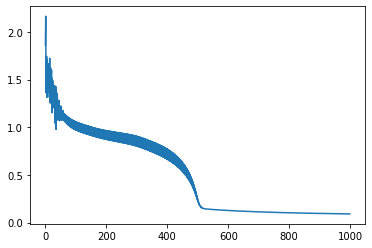

In [25]:
lr = 1e-3
steps = 1000

iris_data = load_iris()
feats = iris_data['data']
gt = iris_data['target']

num_samples = feats.shape[0]
num_classes = gt.max() + 1

net = ANN()

net.operations = [linear(in_c=4, out_c=64),
                  sigmoid(),
                  linear(in_c=64, out_c=num_classes)]

loss_func = CrossEntropyLoss(num_classes)

optimize = SGD(lr=lr)

samples = np.split(feats, num_samples, axis=0)
targets = np.split(gt, num_samples, axis=0)
predict = np.random.choice(num_classes, size=num_samples)  # start with random predictions
losses = []

for step in range(steps):
  if (step > 0) and (step % 100 == 0):
    print(f'Step {step+1}/{steps}, Loss = {np.mean(losses):.4f}, Accuracy = {100.0*np.mean(predict==gt):.2f}%')
  loss_per_epoch = 0
  g_losses = []
  
  for idx, sample in enumerate(samples):
    out = net.forward(sample.T)  # Read note above
    loss, g_loss = loss_func(out, targets[idx])
    g_losses.append(g_loss)
    loss_per_epoch += loss.squeeze()
    predict[idx] = np.argmax(out)

  loss_per_epoch = loss_per_epoch/len(samples)
  losses.append(loss_per_epoch)
  # print(f'Loss = {loss_per_epoch:.3f}')
  # Generate gradients to update weights ...
  net.backward(g_losses)
  # Gradients have been generated, time to update weights!
  optimize(net)
  net.zero_grad()

c_mat = confusion_matrix(gt, predict)
c_mat = c_mat.astype('float') / c_mat.sum(axis=1)[:, np.newaxis]
plt.plot(losses)

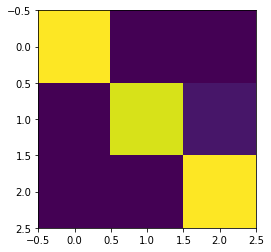

In [26]:
plt.imshow(c_mat)